In [1]:
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots, Statistics
using NeuralOperators, Lux, Optimisers, Zygote
using ConcreteStructs
using MLUtils

In [2]:
#create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
C = randn(obs_dim, latent_dim)
R = Matrix(0.5 * I(10))


# create the state-space model
true_ssm = GaussianLDS(;A=A, 
                        Q=Q, 
                        C=C, 
                        R=R, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, Y = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes
     

([0.02834810073058419 0.4868406514474692 … -1.3814078782247603 -0.9811427748043531; 0.2454727702302156 0.5861771524732997 … -0.04805562025573035 -0.34101350797558994;;;], [-0.6414714145382476 0.0659452576123995 … -0.3358110607670871 -0.4503595728381733; -0.9704737982239324 0.16087982474578807 … 0.40131441455649003 0.5850609469844397; … ; -1.3375761532193409 0.056846227440871255 … 1.7851592562608116 0.7031678406675832; -1.0728333201131601 -0.9939116867737045 … 1.2667399057870559 2.0941803773193772;;;])

In [3]:
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(true_ssm, Y)

([0.34935060008380625 0.5068302002731019 … -1.2302422066003031 -1.1052688282689265; 0.1108217800821371 0.1992761954391749 … 0.180696482579484 -0.21373605139685703;;;], [0.023698915768738685 -0.003822315958390598; -0.003822315958390598 0.03568919623750684;;; 0.025175766123756587 -0.004928495201059508; -0.004928495201059508 0.039684761568941865;;; 0.025315430594397517 -0.005109193865541373; -0.005109193865541373 0.04010699861475666;;; … ;;; 0.025347434112994078 -0.005156789678031886; -0.005156789678031886 0.04033414179471121;;; 0.02561983008614006 -0.005436379325231205; -0.005436379325231205 0.041686103231630085;;; 0.031048287760108435 -0.00803411805917181; -0.00803411805917181 0.05242606509942184;;;;], [0.0 0.0; 0.0 0.0;;; 0.005304178045246432 -0.0040430265539292565; -0.00013589508209314643 0.01185863913877801;;; 0.00571360506963777 -0.004637522967418925; -0.00043730013671773956 0.013153236939416783;;; … ;;; 0.00576827102147888 -0.0047317979497459445; -0.0005013073520938546 0.0133609487

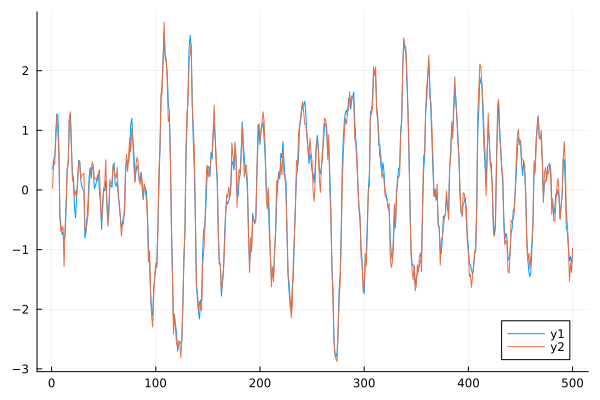

In [4]:
plot(x_smooth[1,:,1])
plot!(latents[1,:,1])

In [5]:
latent_dim = 2             # desired latent state dimension
width = 32                 # FNO channel width
depth = 4                  # number of Fourier layers
modes = 8                  # number of Fourier modes
tin = size(Y, 1)           # observation dimension
T = size(Y,2)

500

In [6]:
y = reshape(Y, T, tin, 1)
y = Float32.(y);

In [7]:
# ---------------------------------------------------
# 2) Build encoder & decoder
# ---------------------------------------------------
width = 32; depth = 4; modes = 8
chs_enc = (tin, fill(width, depth)..., latent_dim)
chs_dec = (latent_dim, fill(width, depth)..., tin)
#encoder = FourierNeuralOperator(elu; chs=chs_enc, modes=(modes,), permuted=Val(true))
decoder = FourierNeuralOperator(elu; chs=chs_dec, modes=(modes,), permuted=Val(true))

FourierNeuralOperator(
    model = Chain(
        layer_1 = Conv((1,), 2 => 32),  # 96 parameters
        layer_2 = Chain(
            layer_1 = OperatorKernel(
                layer = Parallel(
                    connection = Fix1(add_act, elu),
                    layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                    layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                ),
            ),
            layer_2 = OperatorKernel(
                layer = Parallel(
                    connection = Fix1(add_act, elu),
                    layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                    layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                ),
            ),
        ),
        layer_3 = Chain(
            layer_1 = Conv((1,), 32 => 32, elu),  # 1_056 parameters
            layer_2 = Conv((1,), 32 => 1

In [8]:
function encoder(
    rng=Random.default_rng();
    T::Int,
    chs_enc::Tuple{Vararg{Int}},
    modes::Int,
)
    return @compact(;
        #embed=FourierNeuralOperator(elu; chs=chs_enc, modes=(modes,), permuted=Val(true)),
        proj_mu = FourierNeuralOperator(elu; chs=chs_enc, modes=(modes,), permuted=Val(true)),
        proj_log_var=FourierNeuralOperator(elu; chs=chs_enc, modes=(modes,), permuted=Val(true)),
        rng
    ) do x
        #y = embed(x)
        μ = proj_mu(x)
        logσ² = proj_log_var(x)

        T = eltype(logσ²)
        logσ² = clamp.(logσ², -T(20.0f0), T(10.0f0))
        σ = exp.(logσ² .* T(0.5))

        # Generate a tensor of random values from a normal distribution
        rng = Lux.replicate(rng)
        ϵ = randn_like(rng, σ)

        # Reparameterization trick to brackpropagate through sampling
        z = ϵ .* σ .+ μ

        @return z, μ, logσ²
    end
end

encoder (generic function with 2 methods)

In [9]:
enc = encoder(Random.seed!(Random.default_rng(), 1); T, chs_enc, modes)

@compact(
    proj_mu = FourierNeuralOperator(
        model = Chain(
            layer_1 = Conv((1,), 10 => 32),  # 352 parameters
            layer_2 = Chain(
                layer_1 = OperatorKernel(
                    layer = Parallel(
                        connection = Fix1(add_act, elu),
                        layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                        layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                    ),
                ),
                layer_2 = OperatorKernel(
                    layer = Parallel(
                        connection = Fix1(add_act, elu),
                        layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                        layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                    ),
                ),
            ),
            layer_3 = Chain(
       

In [10]:
# ---------------------------------------------------
# 3) Setup parameters, state, optimizers
# ---------------------------------------------------
rng = Random.default_rng()
params_dec, state_dec = Lux.setup(rng, decoder)
params_enc, state_enc = Lux.setup(rng, enc)


((proj_mu = (layer_1 = (weight = Float32[-0.51903737 0.25858915 … 0.43415362 0.40615806;;; 0.41760808 0.016355528 … 0.4687292 -0.4537304;;; 0.4303096 -0.45303038 … 0.38895202 -0.07196127;;; … ;;; -0.25755796 0.29204023 … -0.052270018 -0.41183776;;; -0.49782565 0.257626 … 0.39523652 0.3714925;;; 0.01650394 0.5335923 … 0.0538464 -0.34691098], bias = Float32[-0.29980218, -0.24550596, 0.3030424, 0.27363077, -0.088395014, 0.10244332, -0.17418431, -0.2892126, 0.14531806, -0.3084217  …  -0.14582634, -0.06844158, -0.19099787, 0.15246521, -0.20539032, -0.0047102384, -0.14554976, 0.0728632, -0.21428178, -0.17016341]), layer_2 = (layer_1 = (layer_1 = (weight = Float32[-0.143808 -0.2278259 … -0.058476526 0.27993327;;; -0.18484044 -0.09367959 … 0.23277406 0.2821246;;; 0.0003171506 -0.11978595 … 0.17402151 -0.22678554;;; … ;;; 0.017022217 -0.19188064 … 0.25251794 -0.25015977;;; -0.1471869 -0.08200922 … -0.076839216 -0.29906228;;; 0.23568645 0.25116578 … -0.2941213 -0.14367747], bias = Float32[-0.142

In [11]:
#(z, μ, logσ²), st_enc = vae.encoder(y, ps.encoder, st.encoder)
(z, μ, logσ²), st_enc = enc(y, params_enc, state_enc)

┌ Warning: `replicate` doesn't work for `TaskLocalRNG`. Returning the same `TaskLocalRNG`.
└ @ LuxCore /Users/briandepasquale/.julia/packages/LuxCore/Av7WJ/src/LuxCore.jl:18


((Float32[-0.530813 -0.78768885; -0.16342326 -1.4340271; … ; -0.32617858 1.5070689; -0.5198306 -0.19913924;;;], Float32[0.07730147 -0.3701294; 0.117285684 -0.5301349; … ; -0.41047543 1.5024614; 0.16784832 0.39449567;;;], Float32[-0.4396588 -0.5554476; 0.11033431 0.15020421; … ; -0.19071038 0.27689135; -0.986537 -0.19716512;;;]), (proj_mu = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), proj_log_var = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), rng = TaskLocalRNG()))

In [12]:
# forward pass via Lux.apply: returns latent sequence and updated state
#z, st = Lux.apply(encoder, y, params_enc, state_enc)

# latent_seq has shape (spatial, out_ch, batch) i.e. (T, latent_dim, 1)
println("Encoded latent sequence size: ", size(z))

Encoded latent sequence size: (500, 2, 1)


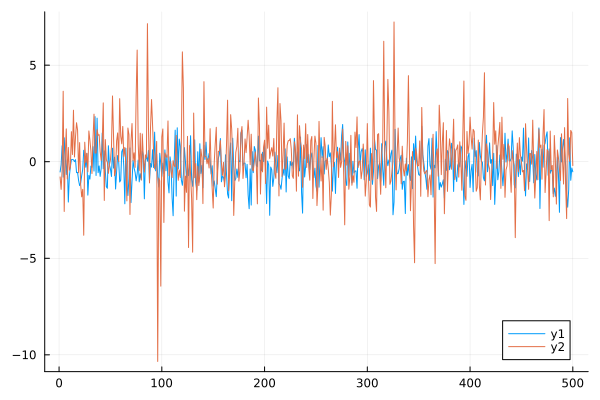

In [13]:
plot(z[:,:,1])

In [14]:
x_rec, st_dec = Lux.apply(decoder, z, params_dec, state_dec)

(Float32[0.2379755 0.38032317 … 0.39230126 -0.22063562; 0.39069518 0.7035916 … 0.68268657 -0.5149148; … ; -1.0080844 -0.9468639 … -1.7180002 0.6643286; -0.06154716 -0.03965736 … -0.018788949 0.023116592;;;], (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())))

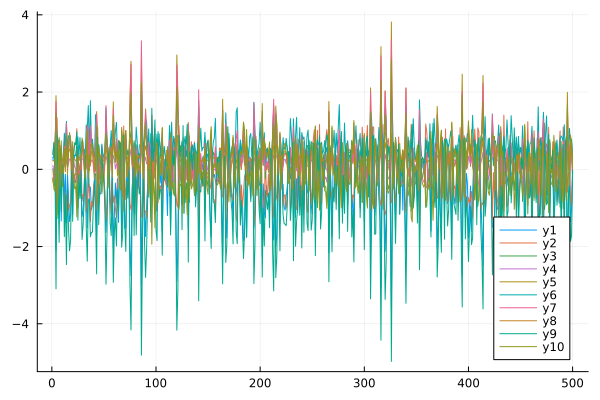

In [15]:
plot(x_rec[:,:,1])

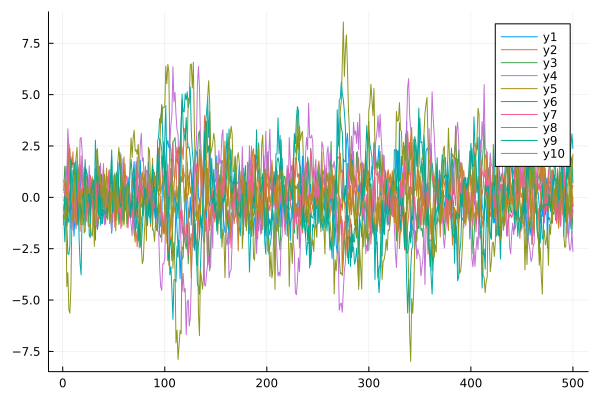

In [16]:
plot(Y[:,:,1]')

## Combine

In [17]:
@concrete struct VAE <: Lux.AbstractLuxContainerLayer{(:encoder, :decoder)}
    encoder <: Lux.AbstractLuxLayer
    decoder <: Lux.AbstractLuxLayer
end

In [18]:
function (vae::VAE)(x, ps, st)
    #z, st_enc = Lux.apply(vae.encoder, y, ps.encoder, st.encoder)
    (z, μ, logσ²), st_enc = vae.encoder(x, ps.encoder, st.encoder)
    x_rec, st_dec = Lux.apply(vae.decoder, z, ps.decoder, st.decoder)
    #(z, μ, logσ²), st_enc = vae.encoder(x, ps.encoder, st.encoder)
    return (x_rec, μ, logσ²), (; encoder=st_enc, decoder=st_dec)
    #return (x_rec, z), (; encoder=st_enc, decoder=st_dec)
end

In [19]:
vae = VAE(enc, decoder)

VAE(
    encoder = @compact(
        proj_mu = FourierNeuralOperator(
            model = Chain(
                layer_1 = Conv((1,), 10 => 32),  # 352 parameters
                layer_2 = Chain(
                    layer_1 = OperatorKernel(
                        layer = Parallel(
                            connection = Fix1(add_act, elu),
                            layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                            layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                        ),
                    ),
                    layer_2 = OperatorKernel(
                        layer = Parallel(
                            connection = Fix1(add_act, elu),
                            layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                            layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
          

In [20]:
ps, st = Lux.setup(rng, vae)

((encoder = (proj_mu = (layer_1 = (weight = Float32[0.3584287 0.07170688 … -0.4524641 0.47765717;;; -0.106974505 0.19874357 … -0.39438236 -0.44647518;;; -0.11533934 -0.3511252 … 0.34369048 0.42545417;;; … ;;; -0.47237605 -0.17407382 … -0.084635146 -0.44611958;;; -0.45423788 0.020128781 … -0.0013704476 0.53291595;;; 0.058669966 -0.18310556 … -0.16689993 -0.3562029], bias = Float32[-0.2988535, -0.25559032, 0.03403443, -0.05716997, 0.012703119, -0.1234346, -0.17314994, 0.18023363, -0.08473065, 0.042811453  …  0.21209565, -0.08274076, -0.19306606, 0.026454862, 0.066109546, -0.19001159, 0.25808114, -0.30070052, 0.09586692, 0.18312539]), layer_2 = (layer_1 = (layer_1 = (weight = Float32[-0.08572082 -0.110066704 … -0.042572677 0.124202915;;; -0.0009607594 -0.0005369186 … 0.12224128 0.007665051;;; -0.15607782 0.044099446 … 0.17965792 -0.19337237;;; … ;;; 0.23949036 -0.13760237 … -0.10377096 0.25609016;;; -0.11601752 -0.20920363 … 0.02384057 -0.159954;;; -0.15689476 0.15908445 … -0.14192013 0.0

In [21]:
vae(y, ps, st)

((Float32[0.31317714 0.45160943 … 0.057245813 0.66146964; -0.45814043 -0.046901256 … 0.13760945 0.98090965; … ; -0.45683178 -0.33816838 … 0.039664738 1.2266206; 0.6215664 0.43695128 … 0.16037354 -0.15397778;;;], Float32[0.9612371 -0.6496893; 0.8329737 -0.19874036; … ; -0.08926427 -0.81687754; -1.3286822 -0.25201166;;;], Float32[-0.5933178 0.11037296; -0.5135187 -0.6340441; … ; 1.2074862 -0.3904449; 0.7761665 0.5548701;;;]), (encoder = (proj_mu = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), proj_log_var = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), rng = TaskLocalRNG()), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTupl

In [22]:
opt = AdamW()

AdamW(eta=0.001, beta=(0.9, 0.999), lambda=0.0, epsilon=1.0e-8, couple=true)

In [23]:
function kl_learned_prior(μ_q, logv_q, μ_p, logv_p)
    σ2_q = exp.(logv_q)
    σ2_p = exp.(logv_p)
    term1 = sum(logv_p .- logv_q)
    term2 = sum((σ2_q .+ (μ_q .- μ_p).^2) ./ σ2_p)
    D = size(μ_q,1)*size(μ_q,2)   # T×d per sample
    return 0.5*(term1 + term2 - D)
  end

kl_learned_prior (generic function with 1 method)

In [24]:
function loss_function(model, ps, st, y)
    #(x_rec, z), st = model(y, ps, st)
    (x_rec, μ, logσ²), st = model(y, ps, st)
    (_, μ_p, logσ²_p), st_enc = model.encoder(zero.(y), ps.encoder, st.encoder)
    reconstruction_loss = MSELoss(; agg=sum)(x_rec, y)
    #kldiv_loss = 0
    #kldiv_loss = -sum(1 .+ logσ² .- μ .^ 2 .- exp.(logσ²)) / 2
    kldiv_loss = kl_learned_prior(μ, logσ², μ_p, logσ²_p)
    loss = reconstruction_loss + kldiv_loss
    #return loss, st, (; y, z, kldiv_loss, reconstruction_loss)
    return loss, st, (; y, μ, logσ², reconstruction_loss, kldiv_loss)
end

loss_function (generic function with 1 method)

In [25]:
loss_function(vae, ps, st, y)

(16167.706298828125, (encoder = (proj_mu = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), proj_log_var = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), rng = TaskLocalRNG()), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()))), (y = Float32[-0.6414714 -0.25129512 … -0.3334053 0.67200685; -0.9704738 -1.4586437 … 1.093093 0.4277825; … ; 0.046798684 0.7536482 … -1.0577263 0.70316786; -0.5147178 4.407649 … -0.83316916 2.0941803;;;], μ = Float32[0.9612371 -0.6496893; 0.8329737 -0.19

In [26]:
train_state = Training.TrainState(vae, ps, st, opt)

TrainState
    model: VAE{CompactLuxLayer{:₋₋₋no_special_dispatch₋₋₋, var"#12#13", Nothing, @NamedTuple{proj_mu::FourierNeuralOperator{Chain{@NamedTuple{layer_1::Conv{typeof(identity), Int64, Int64, Tuple{Int64}, Tuple{Int64}, Tuple{Int64, Int64}, Tuple{Int64}, Int64, Nothing, Nothing, Static.True, Static.False}, layer_2::Chain{@NamedTuple{layer_1::OperatorKernel{Parallel{NeuralOperators.Fix1{typeof(NeuralOperators.add_act), typeof(elu)}, @NamedTuple{layer_1::Conv{typeof(identity), Int64, Int64, Tuple{Int64}, Tuple{Int64}, Tuple{Int64, Int64}, Tuple{Int64}, Int64, Nothing, Nothing, Static.True, Static.False}, layer_2::OperatorConv{Static.True, FourierTransform{ComplexF32, Tuple{Int64}}, typeof(glorot_uniform)}}, Nothing}}, layer_2::OperatorKernel{Parallel{NeuralOperators.Fix1{typeof(NeuralOperators.add_act), typeof(elu)}, @NamedTuple{layer_1::Conv{typeof(identity), Int64, Int64, Tuple{Int64}, Tuple{Int64}, Tuple{Int64, Int64}, Tuple{Int64}, Int64, Nothing, Nothing, Static.True, Static.

In [27]:
losses = Float32[]

Float32[]

In [28]:
for epoch in 1:500
    (_, loss, _, train_state) = Training.single_train_step!(
        AutoZygote(), loss_function, y, train_state; return_gradients=Val(false)
    )
    push!(losses, loss)
end

┌ Warning: Slow fallback implementation invoked for ∇conv_filter!  You probably don't want this; check your datatypes.
│   yT = Float64
│   T1 = Float32
│   T2 = Float64
└ @ NNlib /Users/briandepasquale/.julia/packages/NNlib/CGMj3/src/conv.jl:296
┌ Warning: Slow fallback implementation invoked for ∇conv_data!  You probably don't want this; check your datatypes.
│   yT = Float64
│   T1 = Float64
│   T2 = Float32
└ @ NNlib /Users/briandepasquale/.julia/packages/NNlib/CGMj3/src/conv.jl:243


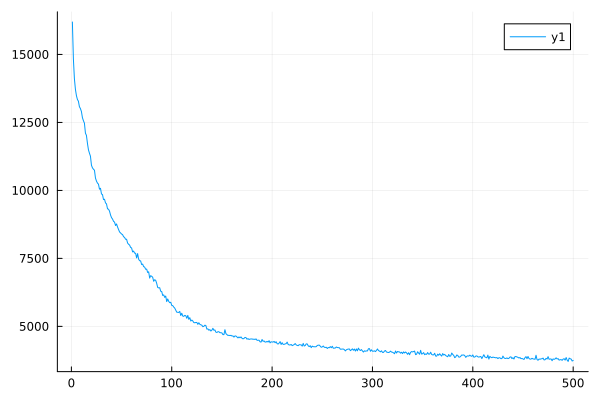

In [29]:
plot(losses)

In [30]:
loss_function(vae, ps, st, y)

(3833.03125, (encoder = (proj_mu = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), proj_log_var = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), rng = TaskLocalRNG()), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()))), (y = Float32[-0.6414714 -0.25129512 … -0.3334053 0.67200685; -0.9704738 -1.4586437 … 1.093093 0.4277825; … ; 0.046798684 0.7536482 … -1.0577263 0.70316786; -0.5147178 4.407649 … -0.83316916 2.0941803;;;], μ = Float32[2.0598109 1.8586237; -0.32960516 0.71016085; 

In [31]:
(recon_seq, latent_seq), st = vae(y, ps, st)

((Float32[-0.9415595 1.495913 … -0.003045559 -0.32444057; -0.6750018 0.2869112 … 0.7172384 -0.48902288; … ; -0.19001223 1.459707 … -0.54657197 1.3366601; -0.02823689 3.2330658 … -0.8143027 1.490329;;;], Float32[2.0598109 1.8586237; -0.32960516 0.71016085; … ; 5.1033487 -0.30073032; 6.4840693 2.5886211;;;], Float32[-0.61175466 -0.9291012; -0.7112453 -1.0572208; … ; -0.47138384 -1.1563451; -0.61704314 -1.4748708;;;]), (encoder = (proj_mu = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), proj_log_var = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), rng = TaskLocalRNG()), decoder = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), lay

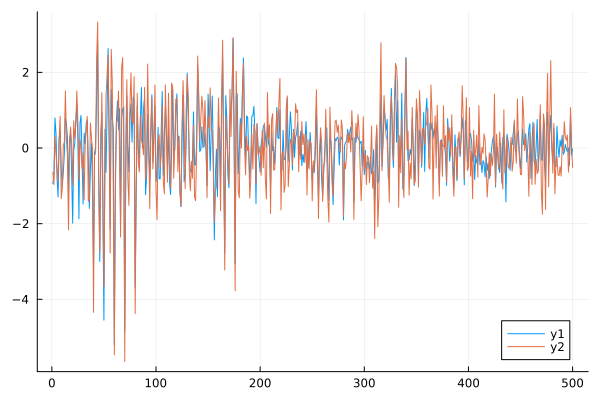

In [32]:
plot(recon_seq[:,1,1])
plot!(y[:,1,1])

In [36]:
latent_seq

500×2×1 Array{Float32, 3}:
[:, :, 1] =
  2.05981     1.85862
 -0.329605    0.710161
 -3.51582     1.22868
 -6.80852     1.94839
 -0.16653     1.86261
  5.30305     0.454029
 -3.21336     0.984365
 -0.496851   -0.246803
  2.33212     0.315653
  7.4696      2.7135
  ⋮          
  0.531574   -0.775697
 -3.46121     0.367381
 -5.73858     2.03429
 -0.0864792  -0.415417
  6.85259     0.417939
 -2.39782     1.00145
 -3.906      -0.303885
  5.10335    -0.30073
  6.48407     2.58862

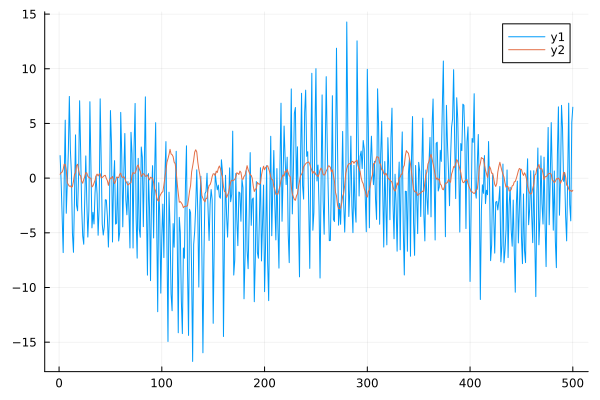

In [33]:
plot(latent_seq[:,1,1])
plot!(x_smooth[1,:,1])

In [37]:
(z_p, μ_p, logσ²_p), st_enc = vae.encoder(zero.(y), ps.encoder, st.encoder)

((Float32[5.2499833 2.924055; -6.135658 1.8417845; … ; -4.8564734 3.0176158; -2.3629975 0.6861332;;;], Float32[-1.4166327 0.50291795; -1.4166327 0.50291795; … ; -1.4166327 0.50291795; -1.4166327 0.50291795;;;], Float32[3.1603892 1.1233749; 3.1603892 1.1233749; … ; 3.1603892 1.1233749; 3.1603892 1.1233749;;;]), (proj_mu = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), proj_log_var = (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), rng = TaskLocalRNG()))

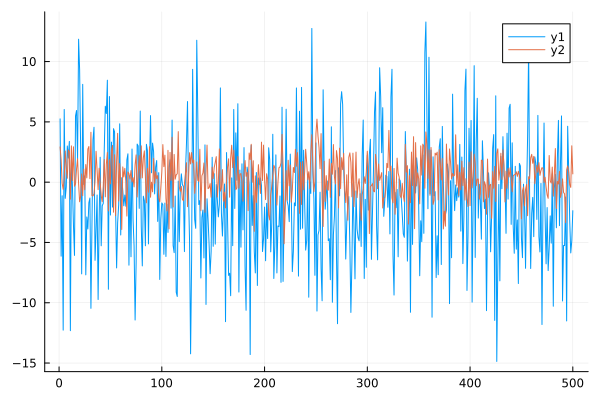

In [38]:
plot(z_p[:,:,1])

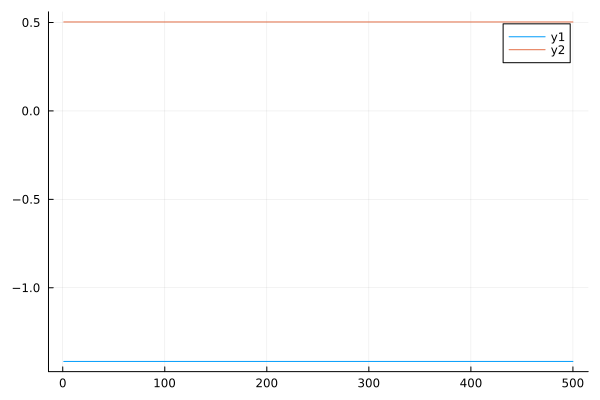

In [39]:
plot(μ_p[:,:,1])

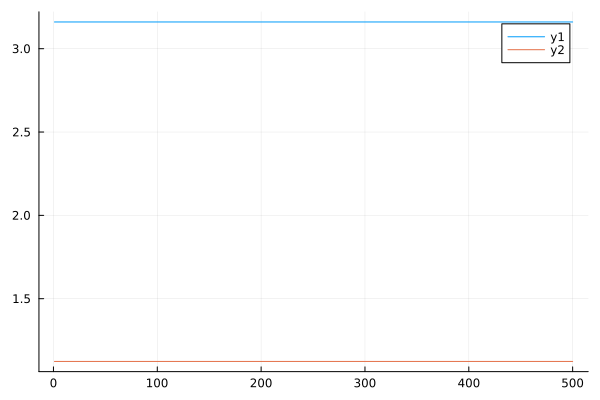

In [40]:
plot(logσ²_p[:,:,1])